##Deep Learning Assignment 1##

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
!pip install statsmodels

In [70]:
data = 'Xtrain.mat'
Traindata = loadmat(data)

In [71]:
# Import necessary library
from scipy.io import loadmat

def load_mat_to_dataframe(file_path):
    """
    Load a .mat file and convert it to a pandas DataFrame.

    Parameters:
    -----------
    file_path : str
        Path to the .mat file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the data from the .mat file
    """
    # Load the .mat file
    mat_data = loadmat(file_path)

    # .mat files typically store data in a dictionary
    # We need to find the actual data arrays (excluding metadata)
    data_dict = {}
    for key, value in mat_data.items():
        # Skip metadata entries (keys that start with '__')
        if not key.startswith('__'):
            # Convert arrays to appropriate format for DataFrame
            if isinstance(value, np.ndarray):
                data_dict[key] = value

    # Create DataFrame from the first array found (modify as needed)
    if data_dict:
        first_key = list(data_dict.keys())[0]
        data_array = data_dict[first_key]

        # If the array is 2D, convert directly to DataFrame
        if len(data_array.shape) == 2:
            df = pd.DataFrame(data_array)
        else:
            # For more complex structures, you might need custom handling
            df = pd.DataFrame({'data': [data_array]})

        return df, data_dict
    else:
        return pd.DataFrame(), {}

# Example usage
df, mat_dict = load_mat_to_dataframe('Xtrain.mat')


#EDA


Shape of the training data: (1000, 1)
Data type: uint8
Min value: 2
Max value: 255

Basic Statistics:
Mean: 59.894
Standard deviation: 46.85198783402898
Variance: 2195.108764


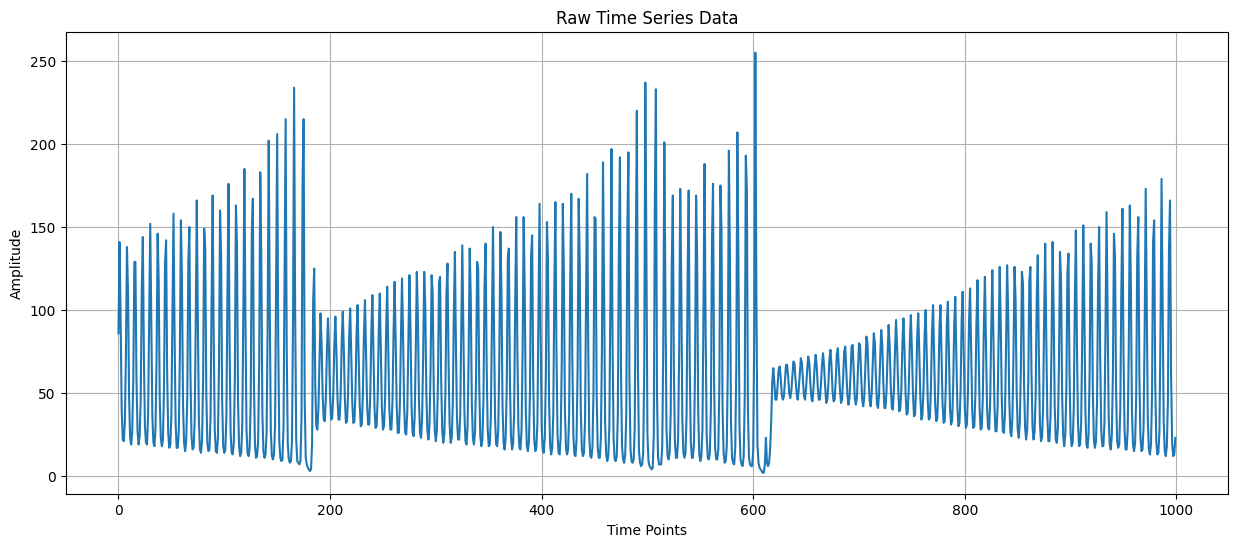

<Figure size 1200x600 with 0 Axes>

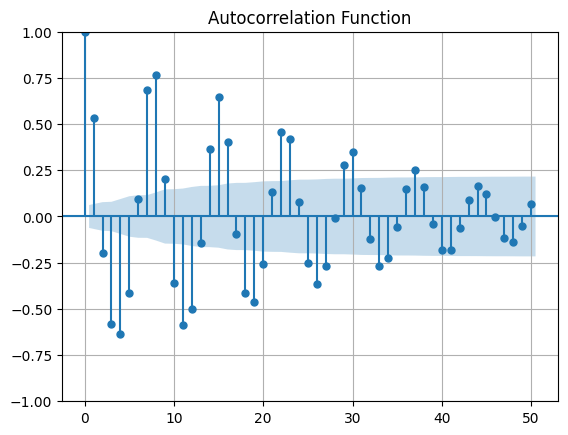

In [72]:
#Load the data
Traindata = mat_dict['Xtrain']
Trainarray = np.array(Traindata)

# Print basic information about the data
print("Shape of the training data:", Trainarray.shape)
print("Data type:", Trainarray.dtype)
print("Min value:", np.min(Trainarray))
print("Max value:", np.max(Trainarray))

# Basic statistics
print("\nBasic Statistics:")
print("Mean:", np.mean(Trainarray))
print("Standard deviation:", np.std(Trainarray))
print("Variance:", np.var(Trainarray))

# Plot the raw time series
plt.figure(figsize=(15, 6))
plt.plot(Trainarray)
plt.title('Raw Time Series Data')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# If the data has multiple time series (columns), plot a few samples
if len(Trainarray.shape) > 1 and Trainarray.shape[1] > 1:
    num_samples = min(5, Trainarray.shape[1])
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(Trainarray[:, i])
        plt.title(f'Time Series Sample {i+1}')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compute autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 6))
if len(Trainarray.shape) > 1 and Trainarray.shape[1] > 1:
    # If multiple time series, use the first one
    plot_acf(Trainarray[:, 0], lags=50, title='Autocorrelation Function')
else:
    # If single time series
    plot_acf(Trainarray, lags=50, title='Autocorrelation Function')
plt.grid(True)
plt.show()


#Data Preprocessing

Scaled data shape: (1000, 1)
Scaled data min: 0.0
Scaled data max: 1.0


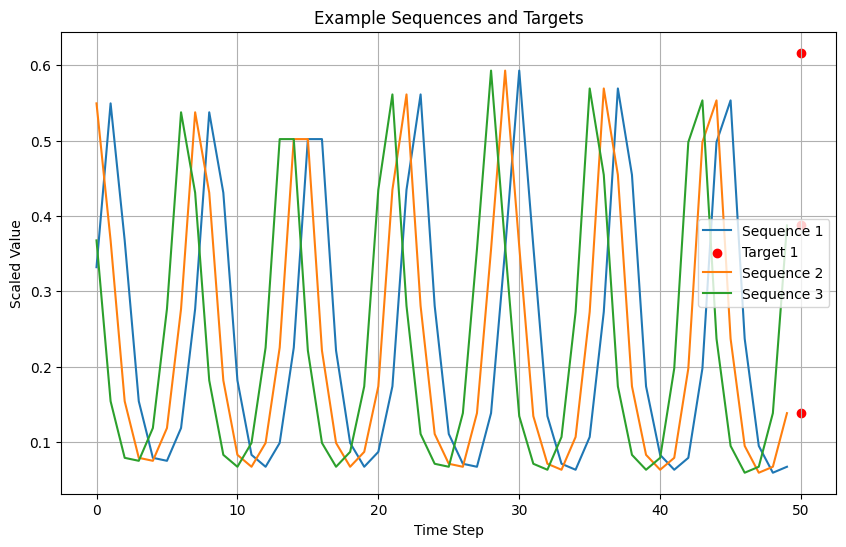

In [73]:
scaler = MinMaxScaler()

# scaler = StandardScaler()

# Reshape data if needed (scaler expects 2D array)
if len(Trainarray.shape) == 1:
    Trainarray_reshaped = Trainarray.reshape(-1, 1)
else:
    Trainarray_reshaped = Trainarray

# Fit the scaler on training data and transform
scaled_train = scaler.fit_transform(Trainarray_reshaped)

# Convert back to original shape if needed
if len(Trainarray.shape) == 1:
    scaled_train = scaled_train.flatten()

print("Scaled data shape:", scaled_train.shape)
print("Scaled data min:", np.min(scaled_train))
print("Scaled data max:", np.max(scaled_train))



# Visualize a few sequences
plt.figure(figsize=(10, 6))
for i in range(min(3, len(X_train))):
    plt.plot(X_train[i], label=f'Sequence {i+1}')
    plt.scatter(window_size, y_train[i], color='red', label=f'Target {i+1}' if i == 0 else "")
plt.title('Example Sequences and Targets')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()


Model Selection & Motivation:
1. Using an LSTM (Long Short-Term Memory) network for this time series prediction task.
2. Justification: 
   - LSTMs can capture long-range temporal dependencies in the laser measurement data
   - They effectively mitigate vanishing-gradient issues common in sequential data
   - Laser measurements likely contain complex temporal patterns that LSTMs are well-suited to learn
   - LSTMs have proven effective for similar time series forecasting tasks


In [74]:
# 4.1 LSTM Model Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size)

        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Apply dropout
        out = self.dropout(lstm_out)
        # Linear layer for prediction
        out = self.fc(out)
        return out

# Create the model
def create_lstm_model(hidden_size=50, dropout_rate=0.2):
    model = LSTMModel(input_size=1, hidden_size=hidden_size, dropout_rate=dropout_rate)
    return model

# Create the model
model = create_lstm_model()
print(model)


# 4.3 Training Setup
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False

early_stopping = EarlyStopping(patience=10)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))
y_val_tensor = torch.FloatTensor(y_val)


LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [75]:
# 3.2 Create sequences (input-output pairs)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Input sequence (X): time steps [i to i+window_size-1]
        X.append(data[i:i+window_size])
        # Target value (y): time step [i+window_size]
        y.append(data[i+window_size])
    return np.array(X), np.array(y)



Training with window size: 5
Epoch [10/100], Train Loss: 0.0577, Val Loss: 0.0530
Epoch [20/100], Train Loss: 0.0361, Val Loss: 0.0320
Epoch [30/100], Train Loss: 0.0369, Val Loss: 0.0320
Epoch [40/100], Train Loss: 0.0337, Val Loss: 0.0305
Epoch [50/100], Train Loss: 0.0334, Val Loss: 0.0299
Epoch [60/100], Train Loss: 0.0328, Val Loss: 0.0283
Epoch [70/100], Train Loss: 0.0317, Val Loss: 0.0270
Epoch [80/100], Train Loss: 0.0292, Val Loss: 0.0253
Epoch [90/100], Train Loss: 0.0276, Val Loss: 0.0223
Epoch [100/100], Train Loss: 0.0228, Val Loss: 0.0183
Training complete for window size 5! Final validation loss: 0.0183

Training with window size: 10
Epoch [10/100], Train Loss: 0.0366, Val Loss: 0.0325
Epoch [20/100], Train Loss: 0.0363, Val Loss: 0.0321
Epoch [30/100], Train Loss: 0.0351, Val Loss: 0.0319
Early stopping at epoch 35
Training complete for window size 10! Final validation loss: 0.0319

Training with window size: 20
Epoch [10/100], Train Loss: 0.0487, Val Loss: 0.0442
Epo

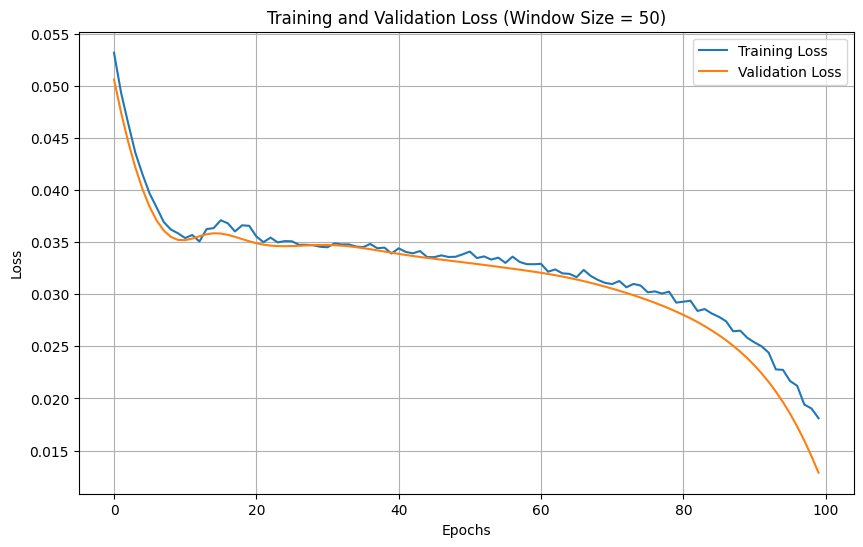

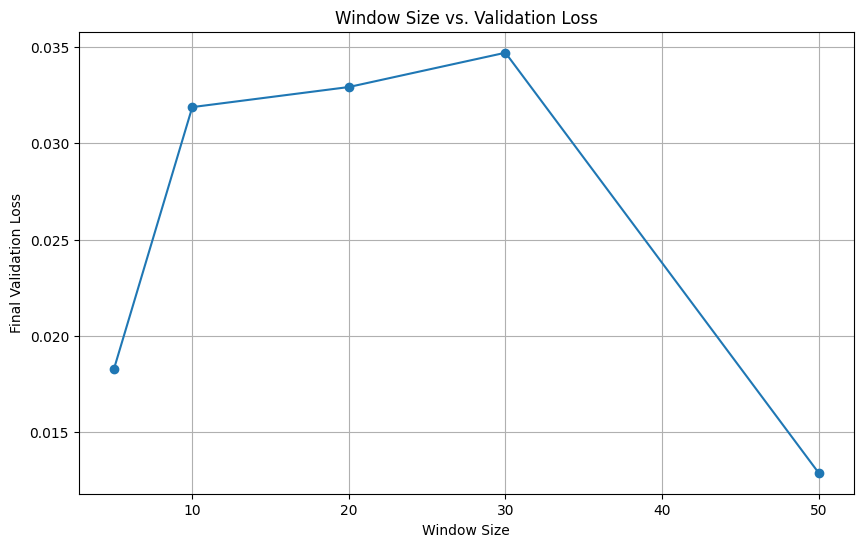

In [76]:
# 4.4 Training Loop with Different Window Sizes
window_sizes = [5, 10, 20, 30, 50]  # Different window sizes to try
num_epochs = 100
results = {}

for window_size in window_sizes:
    print(f"\nTraining with window size: {window_size}")

    # Create sequences with the current window size
    # X, y = create_sequences(scaled_train, window_size)
    # print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Split into training and validation sets
    # Use 80% for training and 20% for validation
    # First split the raw data
    raw = scaled_train
    split_idx = int(len(raw) * 0.8)
    train_raw, val_raw = raw[:split_idx], raw[split_idx:]

    # Then create sequences separately for each set
    X_train, y_train = create_sequences(train_raw, window_size=window_size)
    X_val, y_val = create_sequences(val_raw, window_size=window_size)

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))
    y_val_tensor = torch.FloatTensor(y_val)

    # Create a new model for each window size
    model = create_lstm_model()
    optimizer = optim.Adam(model.parameters())
    early_stopping = EarlyStopping(patience=10)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # Check early stopping
        if early_stopping(val_loss.item(), model):
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Store results for this window size
    results[window_size] = {
        'model': model,
        'final_val_loss': val_loss.item(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }

    print(f'Training complete for window size {window_size}! Final validation loss: {val_loss.item():.4f}')

# Find the best window size
best_window_size = min(results.keys(), key=lambda w: results[w]['final_val_loss'])
print(f"\nBest window size: {best_window_size} with validation loss: {results[best_window_size]['final_val_loss']:.4f}")

# Plot training and validation loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(results[best_window_size]['train_losses'], label='Training Loss')
plt.plot(results[best_window_size]['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (Window Size = {best_window_size})')
plt.legend()
plt.grid(True)
plt.show()

# Plot final validation loss for each window size
plt.figure(figsize=(10, 6))
window_sizes_list = sorted(results.keys())
val_losses_list = [results[w]['final_val_loss'] for w in window_sizes_list]
plt.plot(window_sizes_list, val_losses_list, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Final Validation Loss')
plt.title('Window Size vs. Validation Loss')
plt.grid(True)
plt.show()
